<a href="https://colab.research.google.com/github/Vivek-1116/SDAE-and-VAE-for-Cancer-Classification-through-Multi-omics-Feature-Extraction/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/greenelab/tybalt/blob/master/tybalt_vae.ipynb

# VARIATIONAL AUTOENCODER MODEL (VAE)
This model includes Feature Selection (FS) technique "Recursive Feature Elimination (RFE)" and Class Imbalance algorithm "Synthetic Minority Oversampling Technique (SMOTE)" to further reduce data complexity & enhance computational efficiency.

INSTALL MODULES

In [ ]:
# Supports nested progress bars
!pip install keras_tqdm

IMPORT LIBRARIES

In [ ]:
import os # Standard library within Python 3
import numpy as np # Lib for multi-dimensional arrays and matrices handling 
import pandas as pd # Lib for data manipulation and analysis

%matplotlib inline
import matplotlib.pyplot as plt # Lib for interactive plots
plt.style.use('seaborn-white') # Sets theme of visualization (seaborn-ticks / whitegrid) are similar to white
import seaborn as sns # Matplotlib based lib - better interface for drawing attractive and informative statistical graphics
sns.set_palette(['#FC4B60','#06B1F0'])
random_seed = 63445 

import warnings # Lib for warning issue handling
warnings.filterwarnings('ignore') # Ignores all irrelevant warnings
from collections import Counter

from sklearn import svm # SVM model for RFE Feature Selection
from sklearn.preprocessing import MinMaxScaler # Feature scaling
from sklearn.model_selection import train_test_split # Splitting data into training and test set
from imblearn.over_sampling import SMOTE # Oversample data using SMOTE algorithm

# Framework / Platform for building ML models
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Activation
from tensorflow.keras.layers import BatchNormalization
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.callbacks import Callback
# tf.disable_v2_behavior()

from keras_tqdm import TQDMNotebookCallback # TQDM progress bar

print("Keras Version:",keras.__version__)
print("TensorFlow Version:",tf.__version__)

Keras Version: 2.4.0
TensorFlow Version: 2.3.0


TENSORFLOW VERSION CONTROL

In [ ]:
tf.executing_eagerly() # True shows that eager execution is enabled

True

SEABORN STYLE DESCRIPTION

In [ ]:
sns.set(style="white", color_codes=True)
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":15,"axes.labelsize":20,
                             'xtick.labelsize':14, 'ytick.labelsize':14})

VAE MODEL FUNCTION

In [ ]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    #import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))
    
    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)


In [ ]:
#np.random.seed(123)

MOUNT DRIVE & SET DATA PATH

In [ ]:
from google.colab import drive # Link notebook with google drive
drive.mount('/content/gdrive/') # To retrieve data from our personal Gdrive (can remove this line if we are about to access data from pc)
#Define path
data_path = '/content/gdrive/My Drive/PSM2 VIVEK/LUSC Dataset/' #Change this path accordingly

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


CHECKING FOR MACHINE RUNTIME TYPE

In [ ]:
#Checking whether your machine running only on CPU or with GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
CUDA_VISIBLE_DEVICES = 1

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7137139231005732982
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10685000546625873654
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1990321801340986365
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11145736384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17762844829896509826
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


IMPORT DATASET

In [ ]:
#Create DataFrame
print("Reading Multi-omics Data")
df = pd.read_csv(data_path + "Complete_MultiOmics.csv", delimiter=",", index_col=0)
nFeatures = len(df.columns) - 2 #First and last column does not hold data to be processed
print("Number of features :", nFeatures)
print("Size of Dataset :", df.shape)

Reading Multi-omics Data
Number of features : 18663
Size of Dataset : (344, 18665)


DISPLAY MULTI-OMICS DATA

In [ ]:
print("Multi-Omics data imported successfully")
df

Multi-Omics data imported successfully


,?|10357,?|10431,?|155060,?|57714,?|653553,?|8225,A1BG|1,A2LD1|87769,A2M|2,A4GALT|53947,AAAS|8086,AACS|65985,AADAT|51166,AAGAB|79719,AAK1|22848,AAMP|14,AARS2|57505,AARSD1|80755,AARS|16,AASDHPPT|60496,AASDH|132949,AASS|10157,AATF|26574,AATK|9625,ABAT|18,ABCA11P|79963,ABCA1|19,ABCA2|20,ABCA3|21,ABCA5|23461,ABCA6|23460,ABCA7|10347,ABCA9|10350,ABCB10|23456,ABCB1|5243,ABCB6|10058,ABCB7|22,ABCB8|11194,ABCB9|23457,ABCC10|89845,...,rs2208123,rs2235751,rs2385226,rs2468330,rs2521373,rs264581,rs2804694,rs2857639,rs2959823,rs348937,rs3818562,rs3936238,rs4331560,rs472920,rs4742386,rs5926356,rs5931272,rs5936512,rs5987737,rs6426327,rs6471533,rs654498,rs6546473,rs6626309,rs6982811,rs6991394,rs715359,rs739259,rs7660805,rs7746156,rs798149,rs845016,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367,rs9839873,Class
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA.18.5592.01,236.8295,1141.0830,88.0285,747.6943,409.8256,498.2193,12.0537,111.0547,2676.6396,2246.0049,833.5312,1965.1173,246.9181,1057.0724,1256.8715,3962.7431,569.7891,693.2700,3203.7257,930.3260,163.6380,164.3686,1859.9215,64.2864,21.9158,51.7432,1202.8089,1341.2474,62.8253,487.2614,36.1611,341.5213,14.9758,1291.2063,26.6642,2960.3360,550.8173,702.4016,191.1789,627.8879,...,0.445828,0.498636,0.973635,0.974207,0.928097,0.460344,0.952743,0.609471,0.906139,0.810115,0.163124,0.154739,0.022984,0.544173,0.832685,0.098743,0.976876,0.943812,0.952602,0.020949,0.519868,0.841502,0.016631,0.923785,0.179910,0.497850,0.419557,0.465892,0.850265,0.461360,0.012726,0.481794,0.239229,0.087837,0.536541,0.022941,0.540579,0.026454,0.045728,1
TCGA.18.5595.01,245.4566,999.4328,68.3494,671.5825,821.0437,423.4260,26.6591,45.0227,7857.6064,193.7039,961.1458,2001.1344,72.8871,889.1095,896.4833,2716.3925,537.1384,513.0459,6287.2944,502.8361,279.3534,346.5683,1592.4560,33.1849,188.3154,101.7754,640.6693,1015.8820,1530.9132,307.7141,14.4640,295.2354,7.6574,442.9949,4.8213,3476.2365,483.5508,228.5876,150.0851,374.3619,...,0.852261,0.516386,0.334989,0.473545,0.055859,0.954779,0.447732,0.615397,0.859717,0.455601,0.959690,0.399521,0.430007,0.691078,0.528738,0.889545,0.015282,0.925424,0.049640,0.037420,0.953146,0.358960,0.017422,0.911405,0.379057,0.500063,0.976334,0.552217,0.036871,0.546697,0.013850,0.396258,0.956542,0.482447,0.566233,0.966587,0.532004,0.510593,0.933625,1
TCGA.21.5782.01,308.5506,923.5955,146.0674,212.3596,1083.1461,767.4157,155.0562,198.5281,9403.2921,1151.6854,1142.6966,1384.2697,39.3258,1355.0562,1052.8090,3691.0112,988.5169,613.4831,7869.6629,719.1011,321.3483,278.6517,2089.8876,48.3146,86.5169,117.4045,1119.1011,861.7978,574.1573,234.8315,51.6854,525.8427,32.5843,277.5281,17.9775,2008.1910,302.2472,831.4607,292.9326,1108.9888,...,0.452553,0.036205,0.967153,0.471226,0.032291,0.438903,0.574025,0.963228,0.610111,0.402136,0.929609,0.030298,0.948934,0.549283,0.696018,0.469880,0.443723,0.696970,0.491719,0.042476,0.956615,0.916568,0.017187,0.513279,0.681604,0.329247,0.511011,0.524875,0.046657,0.028637,0.967372,0.933384,0.544448,0.298030,0.932454,0.030718,0.972964,0.466552,0.930599,1
TCGA.21.5783.01,192.7190,526.9117,150.0900,906.6365,748.4178,607.0371,144.2199,47.5353,5312.0566,340.8233,969.9239,1179.2371,190.1527,1441.6768,1964.2339,2394.7628,663.5749,453.7537,3939.4995,681.6466,291.4707,593.3926,903.1528,115.8335,306.2765,15.7551,1544.1125,1215.5258,372.7574,236.3119,28.7406,138.7679,10.7415,265.9235,21.4829,640.6666,548.9752,1006.2126,238.8841,418.3359,...,0.867139,0.068455,0.029902,0.383294,0.934068,0.032984,0.968455,0.069826,0.936634,0.238830,0.758543,0.971294,0.025164,0.500824,0.960496,0.115242,0.019951,0.039448,0.034378,0.875392,0.510459,0.920425,0.024096,0.064971,0.139338,0.068760,0.971782,0.033474,0.629115,0.032588,0.967869,0.583177,0.020746,0.357359,0.449217,0.963890,0.455323,0.529334,0.936669,1
TCGA.21.5784.01,161.6057,1196.5056,51.7527,212.7613,3455.4904,557.7795,144.1336,106.4647,20321.8932,1511.4453,470.6403,1242.9503,26.9822,1051.8633,543.6

# RECURSIVE FEATURE ELIMINATION (RFE)

DATA AGGREGATION (FEATURES & TARGETS)

In [ ]:
features = df.iloc[:,1:-1] #Retrieves all rows (1:), leaves last column (,1:-1)
target = df.iloc[:,-1] #Retrieves all rows (1:), retrieves only last column (,-1)
 
print("Features size :", features.shape)
print("Target size :", target.shape)

Features size : (344, 18663)
Target size : (344,)


DATA STANDARDIZATION

In [ ]:
#Setting all dataset into a range of 0 to 1
min_max_scaler = MinMaxScaler(feature_range =(0, 1))  
#Scaled feature 
features = pd.DataFrame(min_max_scaler.fit_transform(features))

SVM MODEL FITTING

In [ ]:
#Set Parameter
C = 1.0
rfeIndex = nFeatures
#Create SVM model using a linear kernel
model = svm.SVC(kernel='linear', C=C).fit(features,target)
coef = model.coef_
#Print co-efficients of features
for i in range(0, nFeatures):
	print (features.columns[i],":", coef[0][i])

Streaming output truncated to the last 5000 lines.
13664 : 0.0011006466549633317
13665 : -0.006809626176560302
13666 : -0.009563901274620958
13667 : 0.0037713894372190904
13668 : -0.003524314751136645
13669 : -0.005201180205951455
13670 : 0.00015773756689554854
13671 : 0.0011401935264449103
13672 : 0.01178871279050083
13673 : -0.005610754992695529
13674 : 0.0017472017298255898
13675 : -0.004027296904634148
13676 : 0.005186599772150444
13677 : -0.002948680893763898
13678 : 0.0030880236414165024
13679 : 0.002004777023027211
13680 : 0.002771795731461066
13681 : -0.00511480116610077
13682 : 3.045311838693541e-05
13683 : -0.012494280701994405
13684 : 0.000925617577225645
13685 : -0.0042682909947086255
13686 : -0.0035080166283504295
13687 : -0.0005715610415816586
13688 : 0.009525331149086456
13689 : 0.008425871913402543
13690 : 0.004514363463464231
13691 : 0.0060969102083518675
13692 : -0.004614624358560437
13693 : -0.003011728134049132
13694 : 0.0023309863124683057
13695 : -0.00337201173378

RFE IMPLEMENTATION

In [ ]:
#Find the minimum weight among features and eliminate the feature with the smallest weight
min = coef[0][0]

for j in range(6663): # To make sure only 12,000 features remain
  index = 0
  j+=1
  for i in range(0, rfeIndex): # Iterates until the final feature
	  if min > coef[0][i]:
		  index = index + 1
		  min = coef[0][i]

  if len(features.columns) == 1:
	  print ("After recursive elimination we have the", features.columns[index], "feature with a score of:", min)

  else:
	  print ("Lowest feature weight is for", features.columns[index], "with a value of:", min)
	  print ("Dropping feature", features.columns[index])  
	  features.drop(features.columns[index], axis = 1, inplace = True)
	  rfeIndex = rfeIndex - 1
	  nFeatures = nFeatures - 1

Streaming output truncated to the last 5000 lines.
Dropping feature 4163
Lowest feature weight is for 4164 with a value of: -0.03870181819654419
Dropping feature 4164
Lowest feature weight is for 4165 with a value of: -0.03870181819654419
Dropping feature 4165
Lowest feature weight is for 4166 with a value of: -0.03870181819654419
Dropping feature 4166
Lowest feature weight is for 4167 with a value of: -0.03870181819654419
Dropping feature 4167
Lowest feature weight is for 4168 with a value of: -0.03870181819654419
Dropping feature 4168
Lowest feature weight is for 4169 with a value of: -0.03870181819654419
Dropping feature 4169
Lowest feature weight is for 4170 with a value of: -0.03870181819654419
Dropping feature 4170
Lowest feature weight is for 4171 with a value of: -0.03870181819654419
Dropping feature 4171
Lowest feature weight is for 4172 with a value of: -0.03870181819654419
Dropping feature 4172
Lowest feature weight is for 4173 with a value of: -0.03870181819654419
Dropping 

FEATURES AFTER RFE

In [ ]:
print("Dataset size after Feature Selection:",features.shape)

Dataset size after Feature Selection: (344, 12000)


NORMALIZED FEATURES

In [ ]:
features

,6663,6664,6665,6666,6667,6668,6669,6670,6671,6672,6673,6674,6675,6676,6677,6678,6679,6680,6681,6682,6683,6684,6685,6686,6687,6688,6689,6690,6691,6692,6693,6694,6695,6696,6697,6698,6699,6700,6701,6702,...,18623,18624,18625,18626,18627,18628,18629,18630,18631,18632,18633,18634,18635,18636,18637,18638,18639,18640,18641,18642,18643,18644,18645,18646,18647,18648,18649,18650,18651,18652,18653,18654,18655,18656,18657,18658,18659,18660,18661,18662
0,0.069151,0.067463,0.217724,0.225006,0.141737,0.066735,0.094982,0.122215,0.024028,0.146093,0.056316,0.144175,0.051982,0.046245,0.045416,0.234547,0.319127,0.002535,0.280583,0.052194,0.173196,0.157016,0.004391,0.056094,0.119829,0.073398,0.028094,0.095019,0.211951,0.205470,0.108407,0.211823,0.463632,0.155255,0.041219,0.311391,0.099447,0.129741,0.274585,0.196968,...,0.004348,0.450798,0.509075,0.991698,0.994987,0.961257,0.460860,0.976613,0.614567,0.937537,0.834879,0.155134,0.144449,0.004869,0.545551,0.852430,0.078023,0.992801,0.975111,0.980821,0.002530,0.510204,0.876023,0.004816,0.952947,0.165975,0.497972,0.413804,0.472908,0.872148,0.463904,0.002373,0.487680,0.235787,0.074008,0.544164,0.001880,0.536490,0.004052,0.019608
1,0.009762,0.004142,0.061243,0.192814,0.000000,0.208720,0.049520,0.378631,0.042989,0.103633,0.152302,0.173641,0.047812,0.334446,0.013247,0.370965,0.305428,0.013989,0.411760,0.130281,0.450333,0.419414,0.007000,0.025493,0.241219,0.072898,0.042136,0.336726,0.119953,0.106390,0.173610,0.169690,0.168148,0.152454,0.070085,0.215687,0.262400,0.167682,0.447303,0.005227,...,0.996753,0.904045,0.528008,0.329093,0.475022,0.032937,0.976891,0.451130,0.620803,0.887254,0.457220,0.987420,0.399098,0.434760,0.698283,0.533542,0.920607,0.005109,0.955744,0.033701,0.019865,0.974179,0.332570,0.005637,0.939694,0.375259,0.500319,0.991799,0.564094,0.012528,0.552529,0.003533,0.396182,0.975351,0.482287,0.575521,0.991184,0.527444,0.519752,0.962743
2,0.451800,0.479117,0.222978,0.275235,0.183903,0.107043,0.064855,0.185694,0.284567,0.149215,0.171071,0.268249,0.032706,0.346585,0.012935,0.378697,0.071363,0.018896,0.500937,0.383021,0.367371,0.225736,0.049664,0.130546,0.160475,0.386705,0.162165,0.026948,0.431685,0.582258,0.199038,0.187532,0.366107,0.324653,0.014276,0.076097,0.257835,0.194703,0.215331,0.045937,...,0.004253,0.458297,0.015816,0.984973,0.472614,0.007854,0.438483,0.582543,0.986803,0.616885,0.400265,0.955990,0.014992,0.982842,0.550864,0.709045,0.473462,0.445177,0.715130,0.497399,0.025187,0.977894,0.960564,0.005393,0.513474,0.693207,0.319271,0.508743,0.535212,0.022870,0.014511,0.988014,0.970745,0.550473,0.291482,0.962283,0.010033,0.992652,0.472839,0.959529
3,0.311544,0.231329,0.504039,0.165586,0.250763,0.115677,0.299326,0.173865,0.061020,0.139798,0.116721,0.211630,0.092506,0.117512,0.016799,0.184023,0.766030,0.001053,0.548652,0.429981,0.512340,0.161808,0.077386,0.152585,0.290816,0.261455,0.191249,0.288910,0.102076,0.111946,0.235767,0.241026,0.181522,0.178081,0.059152,0.268405,0.300223,0.103254,0.009511,0.215934,...,0.011115,0.920637,0.050215,0.012560,0.381291,0.967613,0.014834,0.992962,0.046733,0.970569,0.226297,0.777254,0.993917,0.007171,0.500482,0.986525,0.095602,0.009904,0.022610,0.017692,0.901798,0.500129,0.964908,0.012570,0.033532,0.123337,0.043181,0.987074,0.016135,0.638430,0.018614,0.988527,0.596129,0.010527,0.352867,0.451942,0.988356,0.446547,0.539715,0.965977
4,0.259694,0.386394,0.044652,0.171215,0.380778,0.049798,0.041554,0.161616,0.431645,0.102612,0.172852,0.250926,0.093289,0.398318,0.014289,0.394622,0.201377,0.027353,0.084434,0.086306,0.232222,0.119280,0.063742,0.109341,0.076144,0.150068,0.108159,0.037316,0.073182,0.564327,0.167779,0.138857,0.887300,0.228911,0.034727,0.156846,0.450507,0.197350,0.356928,0.086911,...,0.494686,0.933817,0.026564,0.412369,0.010029,0.427701,0.010718,0.389864,0.014128,0.970354,0.530455,0.467816,0.444534,0.465464,0.985077,0.981888,0.977452,0.003043,0.496258,0.010880,0.006079,0.511514,0.027638,0.468309,0.445663,0.007673,0.025137,0.500798,0.446797,0.984552,0.004851,0.3951

# SYNTHETIC MINORITY OVERSAMPLING TECHNIQUE (SMOTE)

CLASS IMBALANCE COUNTER

In [ ]:
from collections import Counter
counter = Counter(df['Class'])
counter

Counter({0: 35, 1: 309})

CLASS IMBALANCE PLOT (VISUALIZATION)

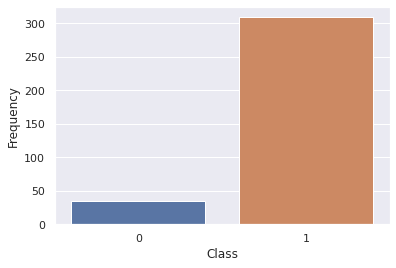

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(df['Class'])
ax.set(xlabel='Class', ylabel='Frequency')
plt.show()

DATA SPLITTING

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42) #0.3
print ("TRAIN DATA SHAPE: ", x_train.shape)
print ("TEST DATA SHAPE: ", x_test.shape)

TRAIN DATA SHAPE:  (258, 12000)
TEST DATA SHAPE:  (86, 12000)


In [ ]:
print ("X TRAIN DATA SHAPE: ", x_train.shape)
print ("X TEST DATA SHAPE: ", x_test.shape)
print ("Y TRAIN DATA SHAPE: ", y_train.shape)
print ("Y TEST DATA SHAPE: ", y_test.shape)

X TRAIN DATA SHAPE:  (258, 12000)
X TEST DATA SHAPE:  (86, 12000)
Y TRAIN DATA SHAPE:  (258,)
Y TEST DATA SHAPE:  (86,)


SMOTE MODEL FITTING

In [ ]:
sm = SMOTE(k_neighbors=1, ratio=1, random_state=random_seed, kind='borderline1')
x_train, y_train = sm.fit_sample(x_train, y_train)
print ('Shape of oversampled data: {}'.format(x_train.shape))
print ('Shape of Y: {}'.format(y_train.shape))

Shape of oversampled data: (470, 12000)
Shape of Y: (470,)


BALANCED DATA VISUALIZATION

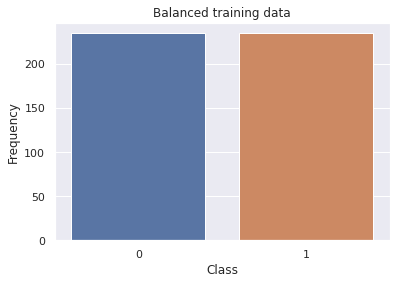

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y_train)
ax.set(xlabel='Class', ylabel='Frequency')
plt.title('Balanced training data')
plt.show()

CLASS (TARGET) AFTER SMOTE

In [ ]:
print('Resampled dataset shape for Train {}'.format(Counter(y_train)))
print('Normal validation dataset shape for Test {}'.format(Counter(y_test)))

Resampled dataset shape for Train Counter({1: 235, 0: 235})
Normal validation dataset shape for Test Counter({1: 74, 0: 12})


# VARIATIONAL AUTOENCODER (VAE)

HYPER-PARAMETER SETTING

In [ ]:
# Set hyper parameters
original_dim = features.shape[1]
latent_dim = 100

batch_size = 4 
epochs = 100 
learning_rate =  0.0005

epsilon_std = 1.0
beta = K.variable(0) 
kappa = 1 

VAE ENCODER & HIDDEN LAYER

In [ ]:
omics_input = Input(shape=(original_dim, ))

z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform', kernel_regularizer = regularizers.l2(0.01))(omics_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform', kernel_regularizer = regularizers.l2(0.01))(omics_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

In [ ]:
# Input place holder for omics data with specific input size
omics_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the omics input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform', kernel_regularizer = regularizers.l2(0.01))(omics_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform', kernel_regularizer = regularizers.l2(0.01))(omics_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

VAE DECODER LAYER

In [ ]:
# The decoding layer is much simpler with a single layer and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform',kernel_regularizer = regularizers.l2(0.01), activation='sigmoid')
omics_reconstruct = decoder_to_reconstruct(z)

VAE MODEL LAYER COMPILATION

In [ ]:
#tf.config.experimental_run_functions_eagerly(True)

adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([omics_input, omics_reconstruct])
vae = Model(omics_input, vae_layer)
vae.compile(optimizer = adam, loss = 'binary_crossentropy', loss_weights = [beta], run_eagerly=True)
vae.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 12000)]      0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 100)          1200100     input_8[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 100)          1200100     input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 100)          400         dense_17[0][0]                   
_______________________________________________________________________________________

TRAINING DATA FORMATTING (SMOTE TO VAE FITTING)

In [ ]:
X = pd.DataFrame(x_train) #Now equal formatting with x_test
Y = pd.Series(y_train) #Now equal formatting with y_test

VAE MODEL FITTING

In [ ]:
%%time
hist = vae.fit(np.array(X,Y),np.array(X,Y),
               shuffle=True,
               epochs=epochs,
               verbose=1,
               batch_size=batch_size,
               validation_data=(np.array(x_test,y_test), np.array(x_test,y_test), None),
               callbacks=[WarmUpCallback(beta, kappa),
                          TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

Epoch 1/100


KeyError: ignored

PRE-TRAINED VAE MODEL LOSS (VISUALIZATION)

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Pre-trained VAE Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
fig = plt.gcf()
plt.show()

SAVE TRAINED VAE MODEL LAYERS

In [ ]:
# DEFINE ENCODER
encoder = Model(omics_input, z)
fold_count = 100

# SAVE THE ENCODER
from keras.models import model_from_json
model_json = encoder.to_json()
with open("encoder" + str(fold_count) + ".json", "w") as json_file:
    json_file.write(model_json)

encoder.save_weights("encoder" + str(fold_count) + ".h5")
print("Saved model to disk")

# DEFINE DECODER
decoder_input = Input(shape=(latent_dim, )) 
decoder_output = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, decoder_output)

ENCODING TEST DATA

In [ ]:
# Encode test data into the latent representation - and save output
test_encoded = encoder.predict(x_test, batch_size = batch_size)
test_encoded_df = pd.DataFrame(test_encoded, index = x_test.index)

DECODING TEST DATA

In [ ]:
# How well does the model reconstruct the input data
test_reconstructed = decoder.predict(np.array(test_encoded_df))
test_reconstructed_df = pd.DataFrame(test_reconstructed, index = x_test.index, columns = x_test.columns)

SAVE DECODED DATA

In [ ]:
# Saving decoded data to feed into classifier
#Result = test_reconstructed_df.to_csv(r'/content/gdrive/My Drive/PSM2 VIVEK/LUSC Dataset/VAE_Decoded_Data.csv')

RECONSTRUCTION ERROR

In [ ]:
from sklearn.metrics import mean_squared_error
reconstruction_error = mean_squared_error(np.array(x_test), np.array(test_reconstructed_df))
print("TEST RECONSTRUCTION ERROR: " + str(reconstruction_error))

RECONSTRUCTION ACCURACY

In [ ]:
Accuracy_rate = 1
accuracy = Accuracy_rate - reconstruction_error
print("VAE MODEL ACCURACY: ",accuracy*100)

CONFUSION METRICS ELEMENTS

In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision2 = precision(y_true, y_pred)
    recall2 = recall(y_true, y_pred)
    return 2*((precision2 * recall2)/(precision2 + recall2 + K.epsilon()))

VAE MODEL - FINE TUNING

In [ ]:
input1 = tf.keras.layers.Input(shape=(original_dim,))
Drop = tf.keras.layers.Dropout(0.2)(input1)

x1 = tf.keras.layers.Dense(6000, activation = 'relu', kernel_initializer= "glorot_uniform")(Drop)
x2 = tf.keras.layers.Dense(6000, activation = 'relu', kernel_initializer= "glorot_uniform")(Drop)      

Adding_layers = tf.keras.layers.Add()([x1, x2])    
x3 = tf.keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer= "glorot_uniform", kernel_regularizer=regularizers.l1_l2(0.01))(Adding_layers)

FT_model = tf.keras.models.Model(inputs = [input1], outputs = x3)
FT_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', recall, precision, f1])
FT_model.summary()
hist2 = FT_model.fit(test_reconstructed_df,y_test, epochs = 50, batch_size = 4, validation_data= (x_test,y_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5, random_state=random_seed)
classifier = rf.fit(x_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
preds = rf.predict(test_reconstructed_df)
confusion_matrix(y_test, preds)

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [ ]:
plot_confusion_matrix(cm           = np.array([[ 3,  9],
                                              [  19, 55]]), 
                      normalize    = False,
                      target_names = ['Non-Cancerous (0)', 'Cancerous (1)'],
                      title        = "Confusion Matrix")

VAE MODEL LOSS (FINE - TUNING)

In [ ]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('VAE Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
fig = plt.gcf()
plt.show()

VAE MODEL ACCURACY (FINE-TUNING)

In [ ]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('VAE Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
fig = plt.gcf()
plt.show()

In [ ]:
encode = []
decode = []
    
Encoder_Weight = encode.append(encoder.layers[0].get_weights())
Decoder_Weight = decode.append(decoder.layers[0].get_weights())

#Pre_enc_weight = tf.keras.layers.Dense(1, activation = 'relu', weights = Encoder_Weight, kernel_regularizer = regularizers.l2(0.01))
#Pre_dec_weight = tf.keras.layers.Dense(1, activation = 'relu', weights = Decoder_Weight, kernel_regularizer = regularizers.l2(0.01))

input1 = tf.keras.layers.Input(shape=(original_dim,))
Drop = tf.keras.layers.Dropout(0.2)(input1)

x1 = tf.keras.layers.Dense(6000, activation = 'relu', kernel_initializer= "glorot_uniform")(Drop)#(Pre_enc_weight)
x2 = tf.keras.layers.Dense(6000, activation = 'relu', kernel_initializer= "glorot_uniform")(Drop)#(Pre_enc_weight)      

Adding_layers = tf.keras.layers.Add()([x1, x2])    
x3 = tf.keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer= "glorot_uniform")(Adding_layers)#(Pre_dec_weight)

FT_model = tf.keras.models.Model(inputs = [input1], outputs = x3)
FT_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', recall, precision, f1])
FT_model.summary()
hist2 = FT_model.fit(test_reconstructed_df,y_test, epochs = 50, batch_size = 4, validation_data= (x_test,y_test)) #16,4